# Clasificación Supervizada de Objetos Astronómicos

El objetivo de este trabajo es analizar la eficiencia y utilidad de diversos modelos de clasificación supervisada.<br>Para esto, se estudiará un caso en especifico; La clasificación de objetos astronómicos, (dada sus carácterisitcas), en una de las 3 siguientes categorías:

* Estrella.
* Galaxia.
* Quasar.

Se tiene a disposición un dataset con 10.000 observaciones registradas por la SDSS, el cual se utilizará para <i>"entrenar"</i> a cada uno de los modelos.

## Importación del Dataset


In [37]:
import pandas as pd
df = pd.read_csv("SDSS-DR14.csv")
df[:4]

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510


## Descripción de los Parámetros

A continuación se detalla el significado de cada parámetro de las observaciones, indicando su tipo y si será utilizado posteriormente por los modelos.

<table style="float:left">
    <tr style="background:#444;color:white">
        <th>Parámetro</th>
        <th>Descripción</th>
        <th>Tipo de Variable</th>
        <th>Utilizada</th>
    </tr>
    <tr>
        <td style='font-weight:bold'>objid:</td>
        <td>Id de la tabla de la cual proviene el dataset.</td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>ra:</td>
        <td>Ángulo de ascensión recta. <a href="https://en.wikipedia.org/wiki/Right_ascension">Más Info</a></td>
        <td>Continua</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>dec:</td>
        <td>Ángulo de declinación. <a href="https://en.wikipedia.org/wiki/Declination">Más Info</a></td>
        <td>Continua</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>u:</td>
        <td>Intensidad del espectro ultravioleta.</td>
        <td>Continua</td>
        <td>Si</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>g:</td>
        <td>Intensidad del espectro verde.</td>
        <td>Continua</td>
        <td>Si</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>r:</td>
        <td>Intensidad del espectro rojo.</td>
        <td>Continua</td>
        <td>Si</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>i:</td>
        <td>Intensidad del espectro infrarojo.</td>
        <td>Continua</td>
        <td>Si</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>z:</td>
        <td>Intensidad del espectro infrarojo lejano.</td>
        <td>Continua</td>
        <td>Si</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>run:</td>
        <td>Largo de la tira actual (ID del escaneo). <a href="https://www.sdss.org/dr16/imaging/imaging_basics/">Más Info</a></td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>rerun:</td>
        <td>Tipo de reprocesamieto del <i>"run"</i>. <a href="https://www.sdss.org/dr16/help/glossary/#rerun">Más Info</a></td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>camcol:</td>
        <td>ID de una de las 6 tiras de la cámara utilizada en la captura. <a href="https://www.sdss.org/dr16/help/glossary/#camcol">Más Info</a></td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>field:</td>
        <td>Fragmento o parte de la tira. <a href="https://www.sdss.org/dr16/help/glossary/#field">Más Info</a></td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>specobjid:</td>
        <td>ID del objeto espectroscópico. <a href="https://www.sdss.org/dr16/help/glossary/#specobj">Más Info</a></td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>class:</td>
        <td>Objeto astronómico detectado.</td>
        <td>Categórica</td>
        <td>Si</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>redshift:</td>
        <td>Velocidad de recesión ( Sirve como medida de distancia a la Tierra ). <a href="https://es.qwe.wiki/wiki/Recessional_velocity">Más Info</a></td>
        <td>Continua</td>
        <td>Si</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>plate:</td>
        <td>ID de la placa utilizada en la captura. <a href="https://blog.sdss.org/2014/09/19/sdss-plates/">Más Info</a></td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>mjd:</td>
        <td>Fecha Juliana modificada, de la noche en que se realizó la observación. <a href="http://scienceworld.wolfram.com/astronomy/ModifiedJulianDate.html">Más Info</a></td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
    <tr>
        <td style='font-weight:bold'>fiberid:</td>
        <td>Id del cable de la placa que realizó la captura.</td>
        <td>Discreta</td>
        <td>No</td>
    </tr>
</table>




## Filtración de Parámetros

Se puede intuir que parámetros que contienen ID's, características sobre la placa utilizada o sobre la estructura de la imagen, y fechas, no aportan información reelevante al problema **( objid, run, rerun, camcol, field, specobjid, plate, mjd, fiberid )**.

Lo mismo ocurre con los parámetros **ra** y **dec**, los cuales indican las coordenadas espaciales de la observación.<br>
Podría ocurrir que en ciertas coordenadas, exista una mayor concentración de objetos astronomicos de algun tipo, en cuyo caso los parámetros podrían ser de utilidad, sin embargo el enfoque del problema es detectar objetos independiente de su ubicación.

Parámetros que sí podrían aportar información reelevante, son los que contienen mediciones de distintos rangos del especto electromagnético **( u, g, r, i, z )**, ya que según la cantidad de cada uno, se puede deducir la composición química del objeto observado, y por ende su tipo.

Otro parámetro que puede ser de utilidad es **redshift**, el cual aporta información respecto a la velocidad con la que el objeto se acerca o aleja de la Tierra, lo cual puede indicar el por qué, de las variaciones en las mediciones de los espectros electromagneticos.

Por último, utilizaremos el parámetro **class**, la cuál será la <i>"variable"</i> dependiente a estudiar **( Y )**.

In [38]:
# Variable objetivo
Y = df["class"]

# Variables predictivas
X = df[['u','g','r','i','z','redshift']]

In [39]:
# Verificamos si existen datos faltantes
Y.isnull().sum()

0

In [40]:
# Verificamos si existen datos faltantes
X.isnull().sum()

u           0
g           0
r           0
i           0
z           0
redshift    0
dtype: int64

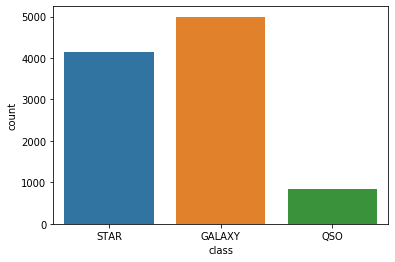

In [41]:
# Verificamos equilibrio
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="class", data=df)
plt.show()

In [42]:
# Normalizamos datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X.values)

In [43]:
# Dividimos dataset en testeo y entrenamiento
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, Y, test_size = .3, random_state=25)
y_train.head()

6625       QSO
2489       QSO
9919    GALAXY
6964    GALAXY
3467      STAR
Name: class, dtype: object

In [44]:
# Entrenamos el modelo
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
# Analizamos su eficiencia
model.score(X_test,y_test)

0.9703333333333334

In [46]:
# Calculamos la matriz de confución para evaluar donde falla el modelo
y_predicted = model.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predicted)
labels = pd.factorize(df['class'])
labels

(array([0, 0, 1, ..., 0, 1, 1]),
 Index(['STAR', 'GALAXY', 'QSO'], dtype='object'))

Text(69.0, 0.5, 'Valor Real')

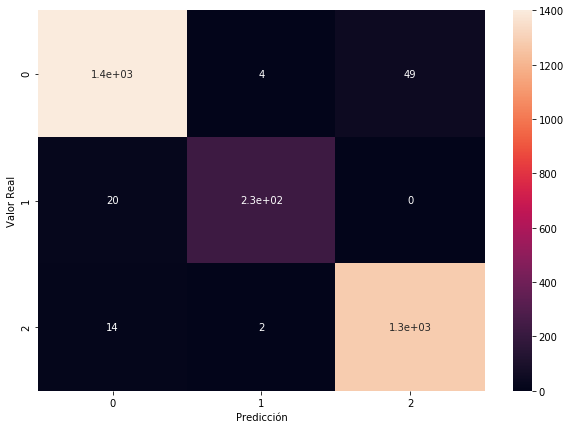

In [47]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm,annot=True)
plt.xlabel("Predicción")
plt.ylabel("Valor Real")

In [48]:
# Ahora con datos equilibrados
starsLen = len(df.loc[df['class'] == "STAR"])
galaxyLen = len(df.loc[df['class'] == "GALAXY"])
qsoLen = len(df.loc[df['class'] == "QSO"])

# Borramos estrellas
indexNames = df[ df['class'] == "STAR" ].index[:starsLen - qsoLen]
df.drop(indexNames , inplace=True)

# Borramos galaxias
indexNames = df[ df['class'] == "GALAXY" ].index[:galaxyLen - qsoLen]
df.drop(indexNames , inplace=True)


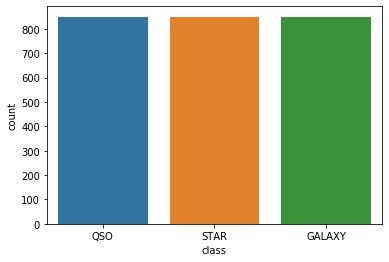

In [49]:
# Verificamos equilibrio
sns.countplot(x="class", data=df)
plt.show()

In [50]:
# Normalizamos datos

Y = df["class"]
X = df[['u','g','r','i','z','redshift']]
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X.values)


In [51]:
model = LogisticRegression()
model.fit(X_normalized,Y)

# Analizamos su eficiencia
model.score(X_test,y_test)

0.535

In [52]:
# Calculamos la matriz de confución para evaluar donde falla el modelo
y_predicted = model.predict(X_test)

In [53]:
cm = confusion_matrix(y_test, y_predicted)
labels

(array([0, 0, 1, ..., 0, 1, 1]),
 Index(['STAR', 'GALAXY', 'QSO'], dtype='object'))

Text(69.0, 0.5, 'Valor Real')

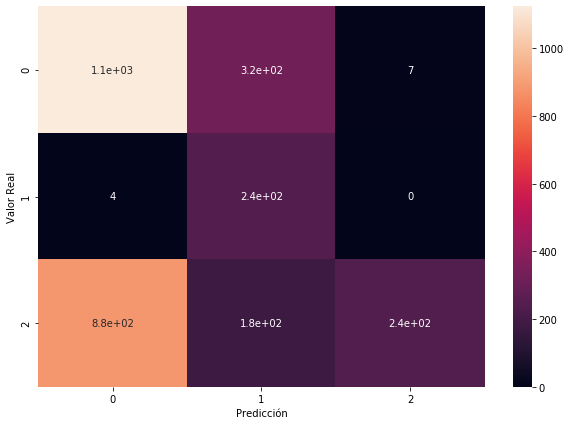

In [54]:
plt.figure(figsize = (10,7))
sn.heatmap(cm,annot=True)
plt.xlabel("Predicción")
plt.ylabel("Valor Real")